Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [185]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.models import Sequential

In [186]:
from numpy.random import seed
seed(52)
tf.random.set_seed(52)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [187]:
# Defining the path for train and test images
# data : https://drive.google.com/drive/u/0/folders/1W0A3orq6rWF5V-WFsbA4DmZMFQWG27fZ
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [188]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [189]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [190]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size,image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="training"
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [191]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size,image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="validation"
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [192]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [193]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [194]:
print(original_df.shape)

(2239, 2)


### Visualize the data
####  code to visualize one instance of all the nine classes present in the dataset

<ipython-input-195-0465cf0c6c91>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, count)


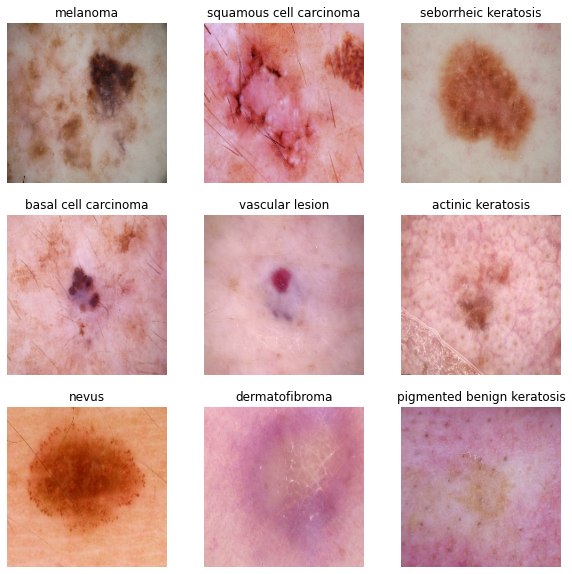

In [195]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(7):
    parsed_labels=[]
    count=1
    for i in range(len(labels)):
        if (labels[i] not in parsed_labels) and (count <=9):
            ax = plt.subplot(3, 3, count)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            parsed_labels.append(labels[i])
            count+=1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [196]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####  a CNN model, which can accurately detect 9 classes present in the dataset. 

In [197]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D , MaxPool2D

In [199]:
num_classes=9
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

### Compile the model

In [200]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [201]:
# View the summary of all layers
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_12 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 22, 22, 64)      

### Train the model

In [202]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 71s 315ms/step - loss: 2.1833 - accuracy: 0.1486 - val_loss: 2.1476 - val_accuracy: 0.2004
Epoch 2/20
169/169 [==============================] - 50s 297ms/step - loss: 2.1264 - accuracy: 0.1955 - val_loss: 2.0405 - val_accuracy: 0.2546
Epoch 3/20
169/169 [==============================] - 50s 299ms/step - loss: 2.0382 - accuracy: 0.2337 - val_loss: 1.8940 - val_accuracy: 0.2769
Epoch 4/20
169/169 [==============================] - 50s 299ms/step - loss: 1.9564 - accuracy: 0.2713 - val_loss: 1.7629 - val_accuracy: 0.3734
Epoch 5/20
169/169 [==============================] - 51s 299ms/step - loss: 1.8900 - accuracy: 0.3042 - val_loss: 1.6587 - val_accuracy: 0.3935
Epoch 6/20
169/169 [==============================] - 51s 302ms/step - loss: 1.6992 - accuracy: 0.3764 - val_loss: 1.5775 - val_accuracy: 0.4506
Epoch 7/20
169/169 [==============================] - 51s 301ms/step - loss: 1.6138 - accuracy: 0.4041 - val_loss: 1.5224 - val_ac

### Visualizing training results

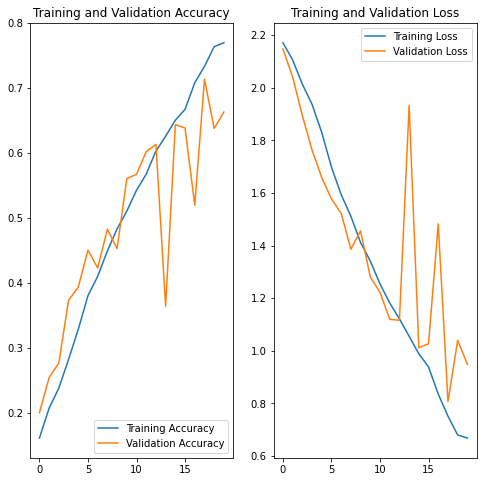

In [203]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model is overfitting as the validation accuracy is highly oscillating

In [204]:
# select first batch of images
image, label = next(iter(train_ds))

In [205]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

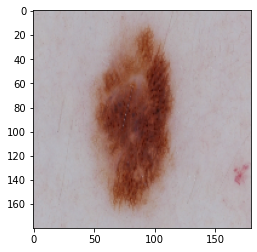

In [206]:
# print an image
plt.imshow(image[0].numpy().astype("uint8"))

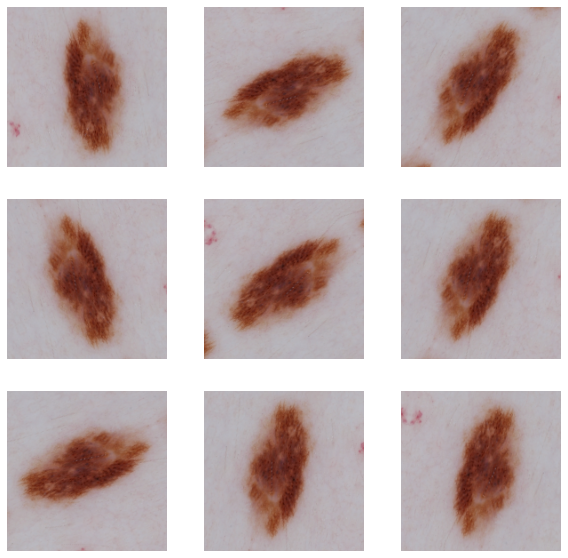

In [207]:
# print rotatio
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### Create the model, compile and train the model

In [208]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [209]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

In [210]:

num_classes=9
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [211]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [212]:
## Your code goes here, note: train your model for 20 epochs
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
169/169 [==============================] - 55s 323ms/step - loss: 2.1765 - accuracy: 0.1557 - val_loss: 2.1631 - val_accuracy: 0.1440
Epoch 2/25
169/169 [==============================] - 54s 321ms/step - loss: 2.1330 - accuracy: 0.1901 - val_loss: 2.0336 - val_accuracy: 0.2584
Epoch 3/25
169/169 [==============================] - 55s 323ms/step - loss: 2.0425 - accuracy: 0.2367 - val_loss: 1.8566 - val_accuracy: 0.3415
Epoch 4/25
169/169 [==============================] - 55s 324ms/step - loss: 1.9123 - accuracy: 0.2868 - val_loss: 1.7267 - val_accuracy: 0.3497
Epoch 5/25
169/169 [==============================] - 55s 325ms/step - loss: 1.7806 - accuracy: 0.3414 - val_loss: 1.7247 - val_accuracy: 0.3504
Epoch 6/25
169/169 [==============================] - 54s 320ms/step - loss: 1.7083 - accuracy: 0.3593 - val_loss: 1.7329 - val_accuracy: 0.3348
Epoch 7/25
169/169 [==============================] - 54s 321ms/step - loss: 1.6667 - accuracy: 0.3705 - val_loss: 1.5318 - val_ac

### Visualizing the results

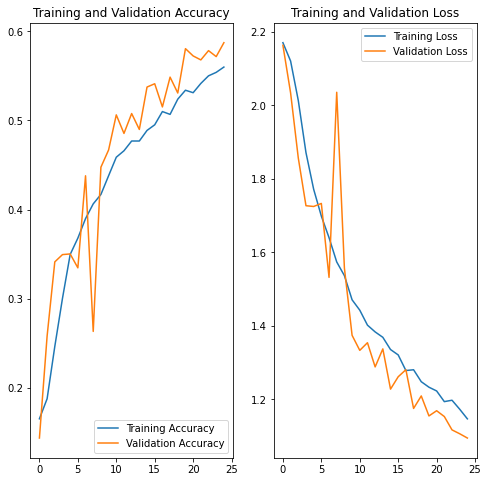

In [213]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We see that model has improved performance as well as the overfitting has reduced compartive to previous model

#### the distribution of classes in the training dataset.


Distribution of images among 9 folders:
- actinic keratosis - 114
- basal cell carcinoma - 376
- dermatofibroma - 95
- melanoma- 438
- nevus - 357
- pigmented benign keratosis - 462
- seborrheic keratosis - 77
- squamous cell carcinoma - 181
- vascular lesion - 139

we have very less number of images for seborrheic keratosis,dermatofibroma,actinic keratosis

In [214]:
for i in class_names:
    directory= pathlib.Path(os.path.join(path_to_training_dataset,i))
    length=len(list(directory.glob('*')))
    print(f'{i} contains {length}')

actinic keratosis contains 114
basal cell carcinoma contains 376
dermatofibroma contains 95
melanoma contains 438
nevus contains 357
pigmented benign keratosis contains 462
seborrheic keratosis contains 77
squamous cell carcinoma contains 181
vascular lesion contains 139


#### Rectify the class imbalance

In [215]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [216]:
path_to_training_dataset=os.path.join("Skin cancer ISIC The International Skin Imaging Collaboration\Train" , "")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2130800A8E0>:   1%| | 3/500 [00:00<00:13

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21309302AC0>: 100%|█| 500/500 [00:04<00:
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2130936CAC0>:   4%| | 20/500 [00:00<00:0

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2130937D160>: 100%|█| 500/500 [00:04<00:00, 124.09 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21308434970>:   2%| | 12/500 [00:00<00:28, 16.95 Samples/s

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21306E4AD00>: 100%|█| 500/500 [00:04<00:00, 116.35 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2137EB2D190>: 100%|█| 500/500 [00:22<00:00, 22.33 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x21306A822E0>: 100%|█| 500/500 [00:19<00:00, 26.01 Sample
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21308110AC0>:   3%| | 16/500 [00:00<00:17, 27.19 Samples/s

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x213069DC910>: 100%|█| 500/500 [00:04<00:00, 119.41 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2130600F610>: 100%|█| 500/500 [00:09<00:00, 52.53 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x213069DCB50>:   2%| | 11/500 [00:00<00:57,  8.44 Samples/s

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21305EF97F0>: 100%|█| 500/500 [00:04<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21308DE1AF0>: 100%|█| 500/500 [00:04<00:00, 117.36 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [217]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [218]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_29e8564d-4d8c-419c-beca-b54d4097c431.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7692c990-c009-4da1-86f6-36643603dc5a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_999593cd-f722-4a06-9d72-238498becd27.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_19224398-7228-48ac-97d5-d38ad0ac1a44.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2d5ac2a8-cec1-47bd-9e2b-6e123a06a188.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [219]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [220]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [221]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [222]:
new_df['Label'].value_counts()

Train                         2239
nevus                          500
actinic keratosis              500
dermatofibroma                 500
squamous cell carcinoma        500
vascular lesion                500
pigmented benign keratosis     500
seborrheic keratosis           500
melanoma                       500
basal cell carcinoma           500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [223]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [224]:
data_dir_train=pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [225]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [230]:
## your code goes here
num_classes=9
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
  layers.Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.0001))
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [231]:
## your code goes here
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [232]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 73s 426ms/step - loss: 2.1996 - accuracy: 0.1541 - val_loss: 2.1022 - val_accuracy: 0.2606
Epoch 2/30
169/169 [==============================] - 73s 430ms/step - loss: 2.0869 - accuracy: 0.2177 - val_loss: 2.3616 - val_accuracy: 0.1559
Epoch 3/30
169/169 [==============================] - 75s 441ms/step - loss: 1.9891 - accuracy: 0.2527 - val_loss: 1.8930 - val_accuracy: 0.3022
Epoch 4/30
169/169 [==============================] - 77s 453ms/step - loss: 1.8856 - accuracy: 0.2920 - val_loss: 2.2772 - val_accuracy: 0.1737
Epoch 5/30
169/169 [==============================] - 78s 458ms/step - loss: 1.7941 - accuracy: 0.3448 - val_loss: 1.6048 - val_accuracy: 0.4336
Epoch 6/30
169/169 [==============================] - 76s 448ms/step - loss: 1.6942 - accuracy: 0.3973 - val_loss: 1.5153 - val_accuracy: 0.4751
Epoch 7/30
169/169 [==============================] - 77s 449ms/step - loss: 1.5519 - accuracy: 0.4417 - val_loss: 1.6522 - val_ac

#### **Todo:**  Visualize the model results

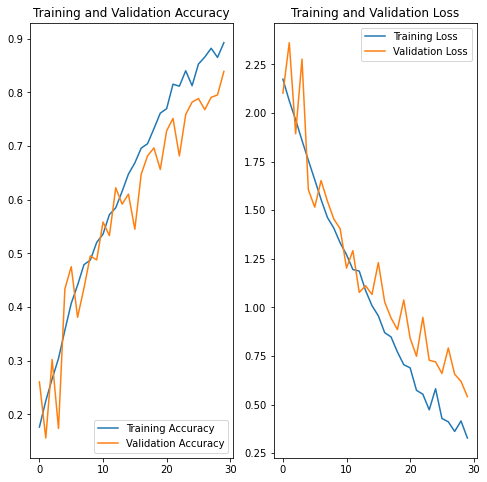

In [233]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model performance got increased to 88% which was possible with help of class rebalance. Overfitting got reduced by some extent as we have increased training data